In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [15]:
growth_data = np.log2(pd.read_csv("./Data/Supplemental_Growth_Curve_FY45.tsv", sep="\t", index_col=0) * 1e6)
growth_data = growth_data.melt(ignore_index=False, var_name="Replicate", value_name="Cells").reset_index()

array(['1', '2', '3', '4', '5', '6'], dtype=object)

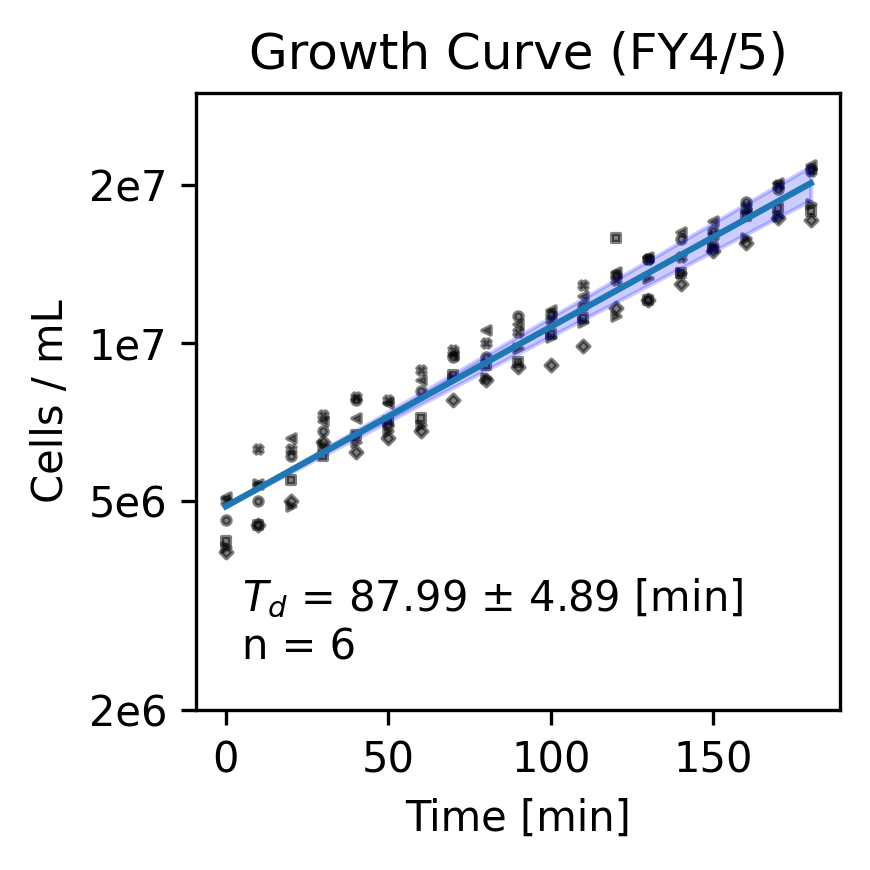

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)

lreg = linregress(
    growth_data['Time'].values, 
    growth_data['Cells'].values
)

td = 1/lreg.slope
td_ci = 1/(lreg.slope - 2.58 * lreg.stderr) - td

x_unique = np.unique(growth_data['Time'])
_markers = {1: "o", 2: "X", 3: ">",
            4: "<", 5: "s", 6: "D"}

for i in range(1, 7):
    ax.scatter(
        x=growth_data.loc[growth_data['Replicate'] == str(i), 'Time'], 
        y=growth_data.loc[growth_data['Replicate'] == str(i), 'Cells'], 
        marker=_markers[i],
        color='black', 
        s=4, 
        alpha=0.5
    )

ax.plot([0, 180], [lreg.intercept, 180 * lreg.slope + lreg.intercept])
ax.fill_between(
    x=x_unique,
    y1=x_unique * (lreg.slope + 2.58 * lreg.stderr) + lreg.intercept,
    y2=x_unique * (lreg.slope - 2.58 * lreg.stderr) + lreg.intercept,
    color='blue',
    alpha=0.2
)

ax.set_ylim([np.log2(2e6), np.log2(3e7)])
ax.set_yticks([np.log2(2e6), np.log2(5e6), np.log2(1e7), np.log2(2e7)])
ax.set_yticklabels(["2e6", "5e6", "1e7", "2e7"])
ax.set_ylabel("Cells / mL")
ax.set_xlabel("Time [min]")
ax.set_title("Growth Curve (FY4/5)")

ax.annotate(f"$T_{{d}}$ = {td:.2f} ± {td_ci:.2f} [min]\nn = 6", xy=(5, 21.25), xycoords='data')

fig.tight_layout()
fig.savefig("growth_curve.png", facecolor="white")

In [3]:
import tqdm
import numpy as np
import scanpy as sc
import anndata as ad

from scipy.sparse import issparse
from scipy import linalg
from scipy.stats import zscore

import sklearn.decomposition
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.utils.fixes import delayed
from sklearn.utils import gen_even_slices

from joblib import parallel_backend as _parallel_backend
from joblib import Parallel, effective_n_jobs

# DEFAULT ALPHA SEARCH SPACE #
# 0 to 10 (LOGSPACE <1 & INCREASING STEPS >1) #
ALPHA_LASSO = np.concatenate((np.array([0]),
                              np.logspace(-4, 0, 21),
                              np.linspace(2, 10, 5)))

def program_select(data, alphas=None, random_state=50, layer='X',
                   n_components=100, normalize=True, threshold='bic',
                   n_jobs=-1, projection='pca', **kwargs):
    """
    Calculate a sparse PCA using sklearn MiniBatchSparsePCA for a range of
    alpha hyperparameters.

    :param data: Data object
    :type data: ad.AnnData
    :param alphas: A 1d array of alpha parameters, defaults to None.
        If None is passed, a default search space will be used
    :type alphas: np.ndarray, optional
    :param batch_size: The batch_size for MiniBatchSparsePCA, defaults to None
    :type batch_size: int, optional
    :param random_state: The random state for MiniBatchSparsePCA, defaults to 50
    :type random_state: int, optional
    :param layer: Data object layer to use, defaults to 'X'
    :type layer: str, optional
    :param n_components: Number of PCs to evaluate, defaults to 100
    :type n_components: int, optional
    :param normalize: Depth-normalize, log-transform, and scale date before PCA,
        defaults to True
    :type normalize: bool, optional
    :param threshold: Select optimization threshold, defaults to 'genes'.
        'genes' selects alpha based on retaining 90% of genes in final model
        'mse' minimizes mean squared error against raw data
        'bic' minimizes BIC of deviance from full PCA model
    :type threshold: str, optional
    :param minibatchsparsepca: Use sklearn MiniBatchSparsePCA, defaults to True
    :type minibatchsparsepca: bool, optional
    :param **kwargs: Additional keyword arguments for sklearn.decomposition object
    :return: Data object with .uns['sparse_pca'], .obsm[], and .varm[] added
    :rtype: ad.AnnData
    """

    if layer == 'X':
        d = ad.AnnData(data.X.astype(float), dtype=float)
    else:
        d = ad.AnnData(data.layers[layer].astype(float), dtype=float)
        
    d.var_names = data.var_names.copy()

    if issparse(d.X):
        d.X = d.X.A

    n, m = d.X.shape

    alphas = ALPHA_LASSO if alphas is None else np.sort(alphas)
    a = alphas.shape[0]

    if normalize:
        # Mask is the same as sc.pp.filter_genes(min_cells=10)
        _keep_gene_mask = np.sum(d.X != 0, axis=0) >= 10

        sc.pp.filter_genes(d, min_cells=10)
        sc.pp.normalize_per_cell(d)
        sc.pp.log1p(d)
        
        # Remove super low-variance genes
        _variance_mask = np.var(d.X, axis=0) > 0.01
        _keep_gene_mask[_keep_gene_mask] = _variance_mask
        d._inplace_subset_var(_variance_mask)
        
    else:
        # Dummy mask
        _keep_gene_mask = np.ones(m, dtype=bool)
        
    m_mean = np.mean(d.X, axis=0)
    d.X = d.X - m_mean[None, :]
    
    if projection == 'pca':
        sk_proj = sklearn.decomposition.PCA
    elif projection == 'ica':
        d.X = zscore(d.X)
        sk_proj = sklearn.decomposition.FastICA

    # Calculate baseline for deviance
    pca_obj = sk_proj(n_components=n_components)
    d.obsm['X_pca'] = pca_obj.fit_transform(d.X)
    d.varm['PCs'] = pca_obj.components_.T
    d.obsm['X_from_pca'] = pca_obj.inverse_transform(d.obsm['X_pca'])

    # Switch order
    d.X = np.asfortranarray(d.X)

    results = {
        'alphas': alphas,
        'loadings': [],
        'full_model_mse': mean_squared_error(d.X, d.obsm['X_from_pca']),
        'mse': np.full(a, fill_value=np.nan, dtype=float),
        'mse_X': np.full(a, fill_value=np.nan, dtype=float),
        'bic': np.full(a, fill_value=np.nan, dtype=float),
        'bic_X': np.full(a, fill_value=np.nan, dtype=float),
        'aic': np.full(a, fill_value=np.nan, dtype=float),
        'aic_X': np.full(a, fill_value=np.nan, dtype=float),
        'nnz': np.zeros(a, dtype=int),
        'nnz_genes': np.zeros(a, dtype=int),
        'nnz_per_component': np.zeros((a, n_components), dtype=int),
        'density': np.zeros(a, dtype=float),
        'deviance': np.full(a, fill_value=np.nan, dtype=float)
    }

    models = []

    for i in tqdm.trange(a):

        mbsp = ParallelLasso(n_components=n_components,
                             n_jobs=n_jobs,
                             alpha=alphas[i],
                             random_state=random_state,
                             **kwargs)

        with _parallel_backend("loky", inner_max_num_threads=1):
            _warm = None if i == 0 else results['loadings'][-1]
            fit_expr = mbsp.fit_transform(d.obsm['X_pca'],
                                          d.X,
                                          warm_start=_warm)
            
        # Append coefficients [Comps x Genes]
        results['loadings'].append(mbsp.components_)

        # SSR
        ssr = np.sum((pca_obj.transform(fit_expr) - d.obsm['X_pca']) ** 2)
        ssr_X = np.sum((fit_expr - d.X) ** 2)

        nnz_per_gene = np.sum(mbsp.components_ != 0, axis=1)

        # Calculate IC from SSR
        results['bic'][i] = n * np.log(ssr / n) + np.sum(nnz_per_gene) * np.log(n)
        results['aic'][i] = n * np.log(ssr / n) + 2 * np.sum(nnz_per_gene)
        
        # Calculate IC for the entire model based on X
        results['bic_X'][i] = n * np.log(ssr_X / n) + np.sum(nnz_per_gene) * np.log(n)
        results['aic_X'][i] = n * np.log(ssr_X / n) + 2 * np.sum(nnz_per_gene)

        # Add summary stats
        results['deviance'][i] = ssr
        results['mse'][i] = ssr / d.obsm['X_pca'].size
        results['mse_X'][i] = ssr_X / d.X.size
        results['nnz'][i] = np.sum(nnz_per_gene)
        results['nnz_per_component'][i, :] = np.sum(mbsp.components_ != 0, axis=0)
        results['nnz_genes'][i] = np.sum(nnz_per_gene > 0)
        results['density'][i] = results['nnz'][i] / mbsp.components_.size

        models.append(mbsp)

        if np.sum(nnz_per_gene) == 0:
            break

    # Largest Alpha w/90% of genes
    if threshold == 'genes':
        select_alpha = np.nanargmax(alphas[(results['nnz_genes'] / m) > 0.9])
        
    elif threshold == 'density':
        select_alpha = np.where(results['nnz'] <= m)[0]
        select_alpha = select_alpha[np.nanargmin(alphas[select_alpha])]
        
    # All other metric thresholds
    elif threshold in results:
        select_alpha = np.nanargmin(results[threshold])
    else:
        _msg = f"threshold={threshold} is not a valid argument"
        raise ValueError(_msg)

    results['opt_alpha'] = alphas[select_alpha]
    
    output_key = layer + "_sparsepca"

    # Pad components with zeros if some genes were filtered during normalization
    # Also transpose to Genes x Comps
    if results['loadings'][0].shape[0] != data.shape[1]:
        for i in range(len(results['loadings'])):
            v_out = np.zeros((data.shape[1], n_components), dtype=float)
            v_out[_keep_gene_mask, :] = results['loadings'][i].T
            results['loadings'][i] = v_out

    
    # Get genes for each comp
    results['opt_genes'] = np.array([
        data.var_names[results['loadings'][select_alpha][:, i] != 0].tolist() 
        for i in range(n_components)
    ], dtype=object)

    results['loadings'] = np.array(results['loadings'])

    # Assemble loadings from chosen alphas
    data.varm[output_key] = results['loadings'][select_alpha].copy()    
    data.obsm[output_key] = d.X @ np.linalg.pinv(data.varm[output_key].T)
    data.uns['sparse_pca'] = results

    return data


def top_loadings(proj_matrix, n):
    n_comp, n_feat = proj_matrix.shape
    trim_mat = proj_matrix.copy()
    
    _discard_mask = np.array([np.argsort(np.abs(proj_matrix[i, :]))[0:n_feat-n] for i in range(n_comp)])
    
    for i in range(n_comp):
        trim_mat[i, _discard_mask[i, :]] = 0
    
    return trim_mat


def mask_to_genes(gene_mask, genes):
    n, m = gene_mask.shape
    return np.array([genes[gene_mask[i, :] != 0].tolist() 
                     for i in range(n)], dtype=object)


class ParallelLasso:

    alpha = 1.0
    n_jobs = -1
    ridge_alpha = 0.01

    components_ = None

    @property
    def coef_(self):
        return self.components_

    def __init__(self, alpha=1.0, n_jobs=-1, ridge_alpha=0.01, **kwargs):
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.ridge_alpha = ridge_alpha

    def fit(self, X, Y, warm_start=None, **kwargs):

        n, m = X.shape
        p = Y.shape[1]

        coefs = np.zeros((p, m), dtype=float)

        if self.alpha == 0:

            coefs[:] = linalg.solve(np.dot(X.T, X),
                                    np.dot(X.T, Y),
                                    assume_a='sym').T

        elif self.n_jobs == 1:
            coefs[:] = _lasso(X, Y, alpha=self.alpha)

        else:
            gram = np.dot(X.T, X)

            slices = list(gen_even_slices(p, effective_n_jobs(self.n_jobs)))

            views = Parallel(n_jobs=self.n_jobs)(
                delayed(_lasso)(
                    X,
                    Y[:, i],
                    alpha=self.alpha,
                    precompute=gram,
                    warm_start=warm_start[i, :] if warm_start is not None else None
                    **kwargs,
                )
                for i in slices
            )

            for i, results in zip(slices, views):
                coefs[i, :] = results

        self.components_ = coefs

        return self

    def fit_transform(self, X, Y, **kwargs):

        self.fit(X, Y, **kwargs)
        return self.transform(X)

    def transform(self, X):
        return X @ self.coef_.T


def _lasso(X, y, warm_start=None, **kwargs):

    kwargs['fit_intercept'] = False

    if kwargs['alpha'] <= 0.1 and 'max_iter' not in kwargs:
        kwargs['max_iter'] = 2500

    if warm_start is not None:
        lasso_obj = Lasso(warm_start=True, **kwargs)
        lasso_obj.coef_ = warm_start.copy()
        return lasso_obj.fit(X, y).coef_
    else:
        return Lasso(**kwargs).fit(X, y).coef_

    
import seaborn as sns 
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

def plot_dist_clustermap(d):
    rho = np.abs(spearmanr(d)[0])
    rho[np.triu_indices(rho.shape[1], -1)] = rho.T[np.triu_indices(rho.shape[1], -1)] 
    linkage = hierarchy.linkage(squareform(np.around(1 - rho, 10)), method='average')

    return sns.clustermap(rho, vmin=0, vmax=1, row_linkage=linkage, col_linkage=linkage)

In [4]:
import sklearn.decomposition
from joblib import parallel_backend as _parallel_backend
from sklearn.linear_model import ridge_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import DBSCAN

In [27]:
expt1_idx = data.obs['Experiment'] == 2
expt1_idx &= data.obs['Gene'] == "WT"
expt1 = ad.AnnData(data.X[expt1_idx, :].copy(), 
                   obs=data.obs.loc[expt1_idx, :].copy(),
                   var=data.var.copy(), dtype=int)

rgen = np.random.default_rng(100)
select_shuffle = np.arange(expt1.shape[0])
rgen.shuffle(select_shuffle)
expt1_test = expt1[select_shuffle[:15000], :].copy()

del expt1

expt1_test.X = expt1_test.X.astype(float).A

sc.pp.normalize_per_cell(expt1_test)
sc.pp.log1p(expt1_test)
sc.pp.filter_genes(expt1_test, min_cells=10)

expt1_test.X = expt1_test.X - np.mean(expt1_test.X, axis=0)[None, :]
expt1_test._inplace_subset_var(np.var(expt1_test.X, axis=0) > 0.01)

expt1_test.X = zscore(expt1_test.X)
sc.pp.pca(expt1_test, n_comps=20)



In [28]:
expt1_test

AnnData object with n_obs × n_vars = 15000 × 5223
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'CC'
    var: 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
#mask_to_genes(top_loadings(expt1_test.varm['PCs'].T, 50), expt1_test.var_names)

In [36]:
program_select(expt1_test, normalize=False, threshold='density', projection='pca', n_components=20)

100%|██████████| 27/27 [00:36<00:00,  1.36s/it]


AnnData object with n_obs × n_vars = 15000 × 5223
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'CC'
    var: 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'n_cells'
    uns: 'log1p', 'pca', 'sparse_pca'
    obsm: 'X_pca', 'X_sparsepca'
    varm: 'PCs', 'X_sparsepca'

In [37]:
expt1_test.uns['sparse_pca']

{'alphas': array([0.00000000e+00, 1.00000000e-04, 1.58489319e-04, 2.51188643e-04,
        3.98107171e-04, 6.30957344e-04, 1.00000000e-03, 1.58489319e-03,
        2.51188643e-03, 3.98107171e-03, 6.30957344e-03, 1.00000000e-02,
        1.58489319e-02, 2.51188643e-02, 3.98107171e-02, 6.30957344e-02,
        1.00000000e-01, 1.58489319e-01, 2.51188643e-01, 3.98107171e-01,
        6.30957344e-01, 1.00000000e+00, 2.00000000e+00, 4.00000000e+00,
        6.00000000e+00, 8.00000000e+00, 1.00000000e+01]),
 'loadings': array([[[ 0.00741968, -0.00083292, -0.00588133, ...,  0.01247776,
          -0.01748853, -0.0028153 ],
         [ 0.02251816, -0.01374434, -0.01671948, ..., -0.00415105,
           0.01573844,  0.02463415],
         [ 0.00971533,  0.03567612, -0.00466486, ...,  0.03833276,
          -0.03420171,  0.00051955],
         ...,
         [ 0.01352114, -0.00549746, -0.01076206, ...,  0.01728218,
           0.02081173,  0.00554637],
         [ 0.00776751,  0.00022744, -0.01290032, ..., -0.0

In [30]:
ica = sklearn.decomposition.FastICA(n_components=2, random_state=8787).fit_transform(expt1_test.X)

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

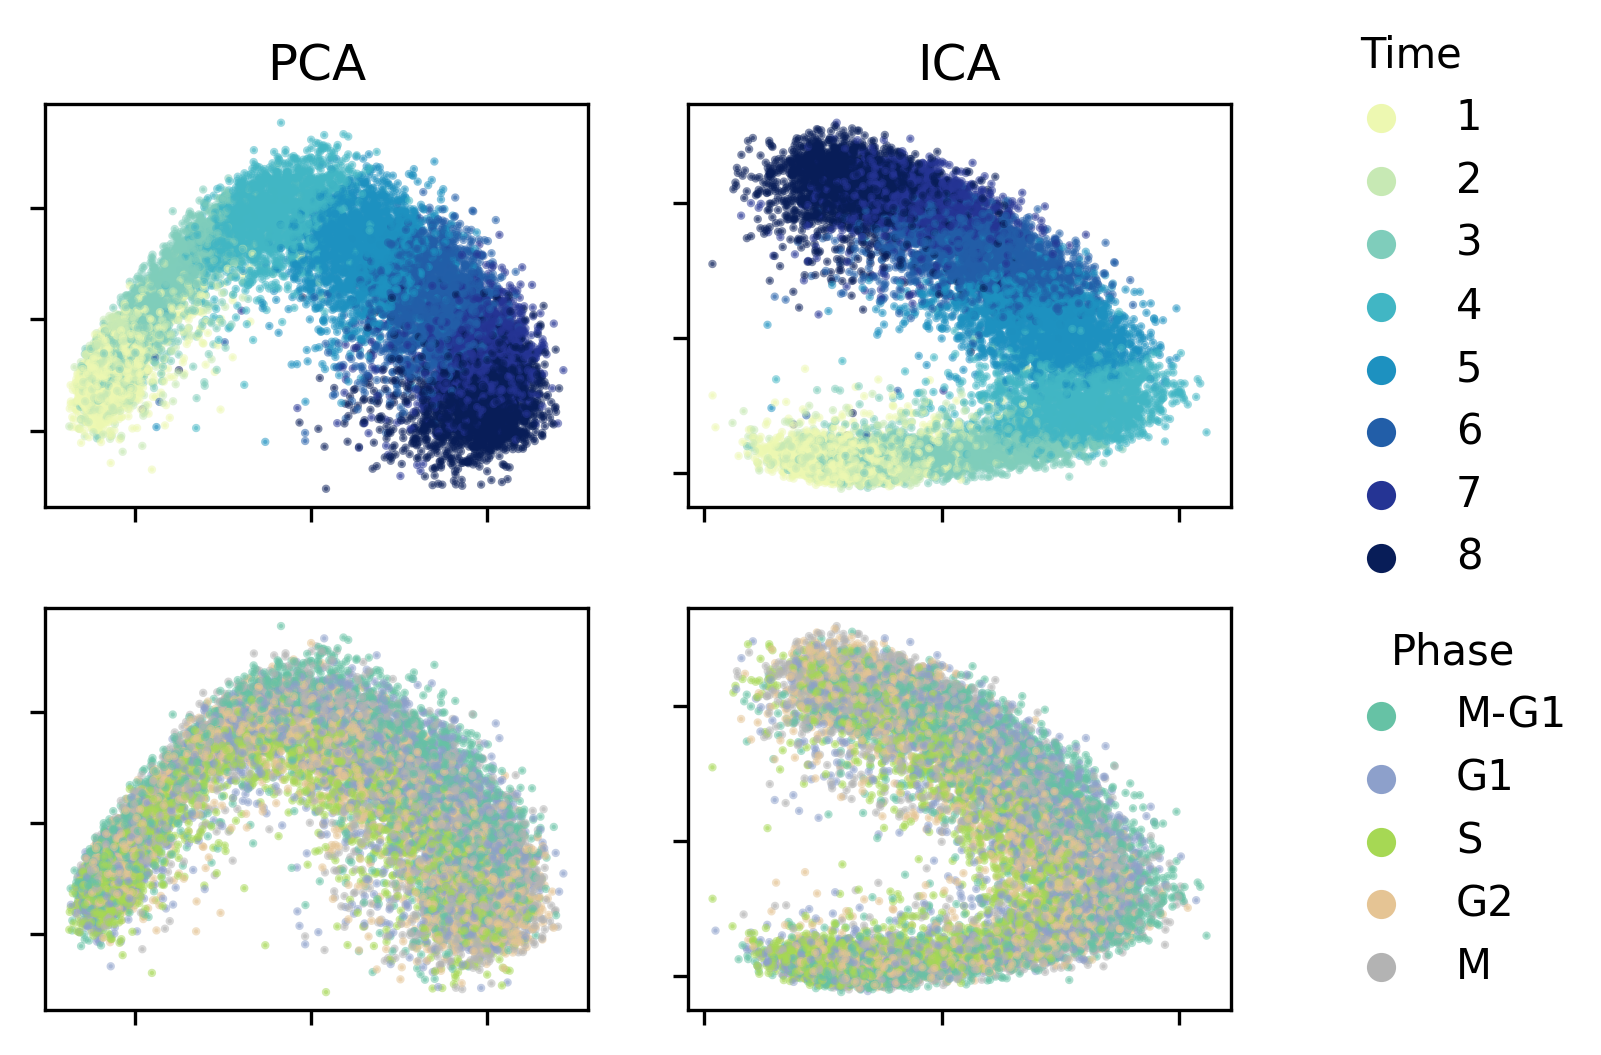

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_common import *

fig, axd = plt.subplot_mosaic([['pca_t', 'ica_t', 'pca_t_cbar'], ['pca_cc', 'ica_cc', 'pca_cc_cbar']],
                              gridspec_kw=dict(width_ratios=[1, 1, 0.2], 
                                               height_ratios=[1, 1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(6, 4), dpi=300)

rgen = np.random.default_rng(123)
overplot_shuffle = np.arange(expt1_test.X.shape[0])
rgen.shuffle(overplot_shuffle)



axd['pca_t'].set_title("PCA")
axd['ica_t'].set_title("ICA")

axd['pca_t'].scatter(expt1_test.obsm['X_pca'][overplot_shuffle, 0], expt1_test.obsm['X_pca'][overplot_shuffle, 1], 
                      c=expt1_test.obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values[overplot_shuffle], 
                      s=1, alpha=0.5)

axd['pca_t'].set_yticklabels([])
axd['pca_t'].set_xticklabels([])

axd['ica_t'].scatter(ica[overplot_shuffle, 0], ica[overplot_shuffle, 1], 
                      c=expt1_test.obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values[overplot_shuffle], 
                      s=1, alpha=0.5)

axd['ica_t'].set_yticklabels([])
axd['ica_t'].set_xticklabels([])

axd['ica_cc'].scatter(ica[overplot_shuffle, 0], ica[overplot_shuffle, 1], 
                      c=expt1_test.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[overplot_shuffle], 
                      s=1, alpha=0.5)
axd['ica_cc'].set_yticklabels([])
axd['ica_cc'].set_xticklabels([])

axd['pca_cc'].scatter(expt1_test.obsm['X_pca'][overplot_shuffle, 0], expt1_test.obsm['X_pca'][overplot_shuffle, 1], 
                      c=expt1_test.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[overplot_shuffle], 
                      s=1, alpha=0.5)
axd['pca_cc'].set_yticklabels([])
axd['pca_cc'].set_xticklabels([])

add_legend(axd['pca_t_cbar'], pool_palette(), list(range(1, 9)), title="Time")
axd['pca_t_cbar'].axis('off')

add_legend(axd['pca_cc_cbar'], cc_palette(), CC_COLS, title="Phase")
axd['pca_cc_cbar'].axis('off')


In [ ]:
pca_obj = PCA().fit(expt1_test.X)

In [ ]:
proj = pca_obj.transform(expt1_test.X)

In [ ]:
mean_squared_error(np.dot(proj, pca_obj.components_), expt1_test.X)

In [ ]:
n = 2000

print(mean_squared_error(expt1_test.X @ pca_obj.components_[0:n, :].T @ pca_obj.components_[0:n, :], expt1_test.X))
print(mean_squared_error(_ridge_rotate(pca_obj.components_[0:n, :], proj[:, 0:n].T), expt1_test.X))

In [ ]:
mean_squared_error(_ridge_rotate(pca_obj.components_[0:100, :], proj[:, 0:100].T), expt1_test.X)

In [ ]:
np.sum(np.eye(100) - (pca_obj.components_[0:100, :] @ linalg.pinv(pca_obj.components_[0:100, :])))

In [ ]:
p = ParallelLasso(alpha=0.1).fit(expt1_test.X, proj[:, 0:100])

In [ ]:
p.coef_.shape

In [ ]:
mean_squared_error(proj @ p.coef_.T, expt1_test.X)

In [ ]:
_lasso(proj, expt1_test.X, alpha=0.1, warm_start=pca_obj.components_)

In [ ]:
mean_squared_error(np.zeros_like(expt1_test.X), expt1_test.X)

In [ ]:
l = Lasso(alpha=1).fit(proj[:, 0:100], expt1_test.X)

In [ ]:
mean_squared_error(proj @ l.coef_.T, expt1_test.X)

In [ ]:
mean_squared_error(p.coef_, l.coef_)

In [ ]:
from sklearn.decomposition import MiniBatchSparsePCA

mbsp_obj = MiniBatchSparsePCA(n_components=100,
                              n_jobs=-1,
                              alpha=0.1,
                              random_state=100,
                              batch_size=100).fit(expt1_test.X)



In [ ]:
mbsp_proj = mbsp_obj.transform(expt1_test.X)

In [ ]:
mbsp_proj @ mbsp_obj.components_

In [ ]:
_ridge_rotate(mbsp_obj.components_, mbsp_proj.T)

In [ ]:
mean_squared_error(expt1_test.X, _ridge_rotate(mbsp_obj.components_, mbsp_proj.T))

In [ ]:
mean_squared_error(expt1_test.X, mbsp_proj @ np.linalg.pinv(mbsp_obj.components_.T))

In [ ]:
ALPHA_LASSO = np.concatenate((np.array([0]),
                              np.logspace(-4, 0, 17),
                              np.linspace(2, 10, 5)))
ALPHA_LASSO

In [ ]:
with _parallel_backend("loky", inner_max_num_threads=1):
    mbsp = sklearn.decomposition.SparsePCA(n_components=100, alpha=10, random_state=100, n_jobs=-1)
    spx = mbsp.fit_transform(expt1_test.X)

In [ ]:
comp_eps = np.finfo(mbsp.components_.dtype).eps
mbsp.components_[np.abs(mbsp.components_) <= comp_eps] = 0.

deviance = ridge_regression(
    mbsp.components_,
    spx.T,
    0.01,
    solver="cholesky"
)

In [ ]:
data

In [ ]:
max(int(expt1.shape[0] / 1000), 5)

In [ ]:
ssr = np.sum((expt1_test.X - deviance) ** 2)
ssr

In [ ]:
np.log(ssr / expt1_test.X.shape[0]) * expt1_test.X.shape[0]

In [ ]:
np.log(expt1_test.X.shape[0]) * np.sum(mbsp.components_ != 0)

In [ ]:
np.sum(data.uns[f"1_WT_sparse_pca"]['loadings'][4] != 0)

In [ ]:
for i in range(1, 3):
    for j in ["WT", "fpr1"]:
        r = data.uns[f"{i}_{j}_sparse_pca"]
        print(f"{i}_{j}_sparse_pca [{r['full_model_mse']:.4f}]")
        print()
        b, m, g, mf = np.argmin(r['bic']), np.argmin(r['mse']), np.where(r['alphas'] == r['opt_alpha'])[0][0], np.argmin(r['mse_full'])
        print(f"BIC: {r['alphas'][b]} [{r['nnz_genes'][b]} / {r['nnz'][b]}]")
        print(f"MSE: {r['alphas'][m]} [{r['nnz_genes'][m]} / {r['nnz'][m]}]")
        print(f"MSE_FULL: {r['alphas'][mf]} [{r['nnz_genes'][mf]} / {r['nnz'][mf]}]")
        print(f"Genes: {r['alphas'][g]} [{r['nnz_genes'][g]} / {r['nnz'][g]}]")
        print("\n")
        


In [ ]:
c = data.uns[f"1_WT_sparse_pca"]['nnz_genes'] / 5751
alphas

In [ ]:
np.sum(data.uns[f"1_WT_sparse_pca"]['loadings'][0] != 0, axis=1)

In [ ]:
np.log(np.mean(resid, axis=0)).max() #+ np.log(n) * np.sum(data.uns[f"1_WT_sparse_pca"]['loadings'][0] != 0, axis=1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_common import *

layout = [['mse_1', 'mse_2', 'mse_3', 'mse_4'],
          ['bic_1', 'bic_2', 'bic_3', 'bic_4'],
          ['nnz_1', 'nnz_2', 'nnz_3', 'nnz_4'],
          ['nng_1', 'nng_2', 'nng_3', 'nng_4'],
          ['nzc_1', 'nzc_2', 'nzc_3', 'nzc_4'],
          ['pcs_1', 'pcs_2', 'pcs_3', 'pcs_4']]

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 1, 1], 
                                               height_ratios=[1, 1, 1, 1, 1, 1],
                                               wspace=0.35, hspace=0.4), 
                              figsize=(6, 9), dpi=300)

for i, (r, g) in enumerate([(1, "WT"), (2, "WT"), (1, "fpr1"), (2, "fpr1")]):
    ref = data.uns[f"{r}_{g}_sparse_pca"]
    opt_loc = np.where(ref['alphas'] == ref['opt_alpha'])[0][0]
    axd[f'mse_{i + 1}'].plot(np.arange(len(ref['alphas'])), ref['mse_full'])
    axd[f'mse_{i + 1}'].axvline(opt_loc, 0, 1, linestyle='--', linewidth=1.0, c='black')
    axd[f'mse_{i + 1}'].set_title(f"{g}_{r}")
    
    axd[f'bic_{i + 1}'].plot(np.arange(len(ref['alphas'])), ref['bic'])
    axd[f'bic_{i + 1}'].axvline(opt_loc, 0, 1, linestyle='--', linewidth=1.0, c='black')
    axd[f'bic_{i + 1}'].annotate(f"α = {ref['opt_alpha']:.3f}", 
                                 xy=(10, 4),  xycoords='data', 
                                 xytext=(0.65, 0.85), textcoords='axes fraction')
        
    axd[f'nnz_{i + 1}'].plot(np.arange(len(ref['alphas'])), ref['nnz'])
    axd[f'nnz_{i + 1}'].axvline(opt_loc, 0, 1, linestyle='--', linewidth=1.0, c='black')

    axd[f'nng_{i + 1}'].plot(np.arange(len(ref['alphas'])), ref['nnz_genes'])
    axd[f'nng_{i + 1}'].axvline(opt_loc, 0, 1, linestyle='--', linewidth=1.0, c='black')
   
    axd[f'nzc_{i + 1}'].scatter(np.arange(ref['varm'].shape[1]),
                                np.sum(ref['varm'] != 0, axis=0),
                                color='black', s=2)
    axd[f'nzc_{i + 1}'].set_yscale('log', base=2)
    axd[f'nzc_{i + 1}'].set_yticks([1, 8, 256, 4096])
    axd[f'nzc_{i + 1}'].yaxis.set_major_formatter(ScalarFormatter())
    
    colors = data.obs.loc[(data.obs['Experiment'] == r) & (data.obs['Gene'] == g), 'Pool']
    colors = colors.map({k: v for k, v in zip(range(1, 9), pool_palette())}).values
    rgen = np.random.default_rng(123 + i)
    overplot_shuffle = np.arange(colors.shape[0])
    rgen.shuffle(overplot_shuffle)

    axd[f'pcs_{i + 1}'].scatter(ref['obsm'][:, 0][overplot_shuffle], 
                                ref['obsm'][:, 1][overplot_shuffle], 
                                color=colors[overplot_shuffle], alpha=0.2, s=1)
    axd[f'pcs_{i + 1}'].set_xticks([])
    axd[f'pcs_{i + 1}'].set_yticks([])

    if i == 0:
        axd[f'mse_{i + 1}'].set_ylabel("MSE")
        axd[f'bic_{i + 1}'].set_ylabel("BIC")
        axd[f'nnz_{i + 1}'].set_ylabel("# NZ Coefs.")
        axd[f'nng_{i + 1}'].set_ylabel("# Genes\n w/ NZ Coef.")
        axd[f'nzc_{i + 1}'].set_ylabel("# NZ Coefs.\n per Comp.")
    
    if i > 0:
        axd[f'nnz_{i + 1}'].set_yticklabels([])
        axd[f'nng_{i + 1}'].set_yticklabels([])
        axd[f'nzc_{i + 1}'].set_yticklabels([])
    

    